### Libraries Import

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch

In [3]:
from transformers import pipeline

/Users/lisa/projects/MTReviews/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loading Models

In [4]:
binary_polarity_pipeline = pipeline("text-classification", model="laskovey/polarity_train2")

In [5]:
multiclass_polarity_pipeline = pipeline("text-classification", model="laskovey/polarity_train5")

### Trying examples

In [6]:
def correcting_output(model_output):
    '''
    A function remapping classes.
    Seems like class mapper got messed up: as if 1 turned 5 and 5 - 1.
    Therefore the function reverses the class order.
    
    Takes model output as list of dicts as input
    Return output of similar format with changed class labels
    '''
    correct_mapper = {1:5, 2:4, 3:3, 4:2, 5:1}
    for k in model_output:
        k['label'] = correct_mapper[int(k['label'])]
    
    return model_output

In [7]:
def calculating_polarity_rating(model_output):
    '''
    A function remapping classes.
    Seems like class mapper got messed up: as if 1 turned 5 and 5 - 1.
    Therefore the function reverses the class order.
    
    Takes model output as list of dicts as input
    Return output of similar format with changed class labels
    '''
    
    pred_labels = np.array([o['label'] for o in model_output])
    pred_proba = np.array([o['score'] for o in model_output])
    
    polarity_rating = np.sum(pred_labels * pred_proba)

    return polarity_rating

In [8]:
def calculating_polarity(model_output):
    '''
    A function remapping classes.
    Seems like class mapper got messed up: as if 1 turned 5 and 5 - 1.
    Therefore the function reverses the class order.
    
    Takes model output as list of dicts as input
    Return output of similar format with changed class labels
    '''
    
    pred_labels = np.array([o['label'] for o in model_output])
    pred_proba = np.array([o['score'] for o in model_output])
    
    polarity = (np.sum(pred_labels * pred_proba) - 3)/2 * 100

    return polarity

In [39]:
def calculating_binary_polarity(model_output):
    '''
    A function transforming output of binary classifier to continuous value from 0 to 1, 
    where 0 - extremely negative, 1 - extremely positive.
    
    Takes model output as list with 1 dict for best prediction as input
    Return output as a single decimal
    '''
    
    polarity = model_output[0]['score']
    
    if model_output[0]['label'] == 0:
        polarity = 1 - polarity
        
    return polarity

Very positive example

In [9]:
ex1 = 'Всё просто супер! Спасибо гиду Наталье за отличеую экскурсия'

In [10]:
binary_polarity_pipeline(ex1)

[{'label': 1, 'score': 0.9990983009338379}]

In [40]:
calculating_binary_polarity(binary_polarity_pipeline(ex1))

0.9990983009338379

In [11]:
correcting_output(multiclass_polarity_pipeline(ex1, top_k=5))

[{'label': 5, 'score': 0.9887393712997437},
 {'label': 3, 'score': 0.007490302436053753},
 {'label': 4, 'score': 0.0032231095246970654},
 {'label': 1, 'score': 0.0002741206844802946},
 {'label': 2, 'score': 0.0002730652631726116}]

In [18]:
calculating_polarity_rating(correcting_output(multiclass_polarity_pipeline(ex1, top_k=5)))

4.979880453116493

Very negative example

In [12]:
ex2 = 'Ужас, полное разводилово!!! Это разве экскурсия?? Вы за что вообще деньги берёте!!!'

In [13]:
binary_polarity_pipeline(ex2)

[{'label': 0, 'score': 0.9984408020973206}]

In [41]:
calculating_binary_polarity(binary_polarity_pipeline(ex2))

0.0015591979026794434

In [14]:
correcting_output(multiclass_polarity_pipeline(ex2, top_k=5))

[{'label': 1, 'score': 0.9652891755104065},
 {'label': 2, 'score': 0.027066640555858612},
 {'label': 3, 'score': 0.0027626364026218653},
 {'label': 5, 'score': 0.0027074560057371855},
 {'label': 4, 'score': 0.0021740878000855446}]

In [19]:
calculating_polarity_rating(correcting_output(multiclass_polarity_pipeline(ex2, top_k=5)))

1.0499439970590174

Seems like class mapper got messed up: as if 1 turned 5 and 5 - 1

Rather neutral example

In [15]:
ex3 = 'Обычная экскурсия, ничего особенного. Монотонный гид с зазубренными фактами. Нормально за свои деньги.'

In [16]:
binary_polarity_pipeline(ex3)

[{'label': 0, 'score': 0.9987196922302246}]

In [42]:
calculating_binary_polarity(binary_polarity_pipeline(ex3))

0.0012803077697753906

In [17]:
correcting_output(multiclass_polarity_pipeline(ex3, top_k=5))

[{'label': 2, 'score': 0.6262772679328918},
 {'label': 1, 'score': 0.23666438460350037},
 {'label': 3, 'score': 0.13439279794692993},
 {'label': 5, 'score': 0.002267968375235796},
 {'label': 4, 'score': 0.0003976335283368826}]

In [41]:
calculating_polarity_rating(correcting_output(multiclass_polarity_pipeline(ex3, top_k=5)))

1.9053276902996004

This kind of transformation may be performed on DataBase side

In [20]:
calculating_polarity(correcting_output(multiclass_polarity_pipeline(ex1, top_k=5)))

98.99402265582466

In [21]:
calculating_polarity(correcting_output(multiclass_polarity_pipeline(ex2, top_k=5)))

-97.50280014704913

In [22]:
calculating_polarity(correcting_output(multiclass_polarity_pipeline(ex3, top_k=5)))

-54.73361548501998

### Predicting for review segments

In [119]:
for_pred_df = pd.read_csv('./aspect_predictions_may24.csv')

In [30]:
for_pred_df.sample(3)

,label,score,input,index,REVIEW_ID,SENTENCES,NUM_SENT,label_rank
1804422,no substance,0.886165,601474,601474,NJZV91862585780616,Много животных,4,1
440945,shallow narration,0.013128,146981,146981,DHIK68100749090426,Практически Ничего не было видно из окон,2,3
3485408,fact misstatement,0.002936,1161802,1161802,ZWUD58477886263728,Были выбраны очень эпичные дворы,3,3


In [31]:
len(for_pred_df)

3503229

In [120]:
for_pred_df.drop_duplicates(['REVIEW_ID', 'NUM_SENT'], keep='first', inplace=True)

Taking a sample for testing

In [35]:
sample = for_pred_df.sample(2000, random_state=42).reset_index()

In [63]:
sample.sample(3)

,level_0,label,score,input,index,REVIEW_ID,SENTENCES,NUM_SENT,label_rank
1806,3369651,food,0.351079,1123217,1123217,ZAHP39617744065997,Валентина и сюда вставила нотку негатива про э...,29,1
1863,332184,offer disparity,0.993466,110728,110728,CMBG52422309292370,"В программе указано три месте: хыналыг, радужн...",8,1
1810,2355069,guide's proficiency,0.997940,785023,785023,RNFG87757161597761,Хороший русскоговорящий гид,2,1


Prediction processing functions

In [53]:
def final_predicted_polarity(text):
    prediction_lst = multiclass_polarity_pipeline(text, top_k=5)
    prediction_lst = correcting_output(prediction_lst)
    polarity = calculating_polarity_rating(prediction_lst)
    
    return polarity

In [68]:
def final_binary_predicted_polarity(text):
    prediction_lst = binary_polarity_pipeline(text, top_k=5)
    polarity = calculating_binary_polarity(prediction_lst)
    return polarity

Trying on examples from sample

In [58]:
final_predicted_polarity('Великолепная экскурсия')

4.9643184290325735

In [59]:
final_predicted_polarity('Очень внимательное отношение к экскурсантам')

3.0123042977647856

In [65]:
final_predicted_polarity('Валентина и сюда вставила нотку негатива про это место, животных и людей, которые не кормят собак, раз они худые')

1.7816753704100847

In [62]:
final_predicted_polarity('Всё во время')

4.513219142332673

In [69]:
final_binary_predicted_polarity('Спасибо большое 😊')

0.9964026212692261

Preparing dataset for prediction

In [66]:
X = sample.SENTENCES.to_list()

In [67]:
%%time
mc_predictions = [final_predicted_polarity(x) for x in X]

CPU times: user 21.3 s, sys: 683 ms, total: 22 s
Wall time: 13.4 s


In [70]:
%%time
bin_predictions = [final_binary_predicted_polarity(x) for x in X]

CPU times: user 19.9 s, sys: 550 ms, total: 20.5 s
Wall time: 12 s


In [71]:
res_df = pd.DataFrame({'sentence': X, 'polarity': mc_predictions, 'bin_polarity': bin_predictions})

In [72]:
res_df

,sentence,polarity,bin_polarity
0,"Путеводитель не предоставлен, за что была взят...",1.569003,0.003109
1,Красивые места,3.219599,0.992325
2,Только цены в баре очень заоблачные,1.647474,0.001239
3,Восхитительный вид на Балтийское море с высоты...,4.872501,0.999421
4,Обязательно поедем с Вами еще на экскурсию,4.926344,0.999226
...,...,...,...
1995,Спасибо вам большое,4.407651,0.993178
1996,"А на бархан Сурыкум мы вообще не попали, начал...",1.620565,0.997516
1997,Рекомендую,4.428528,0.998146
1998,На высоту Эфа поднимались без экскурсовода,2.175936,0.491152


### Multi-class predictions seem rather valid! Let's predict on whole dataset

In [74]:
X = for_pred_df.SENTENCES.to_list()

In [75]:
len(X)

1167743

In [76]:
%%time
mc_predictions = [final_predicted_polarity(x) for x in X]

CPU times: user 3h 40min 59s, sys: 4min 30s, total: 3h 45min 29s
Wall time: 2h 20min 56s


In [77]:
res_df = pd.DataFrame({'sentence': X, 'polarity': mc_predictions})

In [83]:
res_df.sample(5)

,sentence,polarity
187368,Отлично,4.876304
668702,"Очень красиво, познавательно",4.522636
971824,Экскурсию взяли для первого впечатления от Каз...,2.048482
1126127,Списки по людям не скинули людей называли по н...,1.311893
169066,"Гид - умница и красавица, даже маска ей к лицу",4.332927


In [86]:
res_df.loc[1126127, 'sentence']

'Списки по людям не скинули людей называли по номеру телефона'

In [87]:
res_df.to_csv('./sentence_polarity.csv', index=False)

In [112]:
res_df.sample()

,sentence,polarity,polarity_shifted
73354,Всё отлично,4.906863,0.953431


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
res_df['polarity_shifted'] = (res_df.polarity - 3) / 2

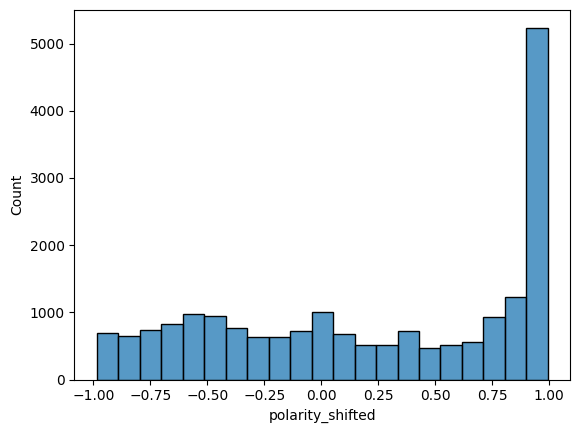

In [97]:


sns.histplot(data=res_df.sample(20000), x='polarity_shifted')
plt.show()

In [88]:
for_db_df = pd.read_csv('./aspect_predictions_for_db.csv')

In [124]:
for_db_df.sample()

,ID,REVIEW_ID,SENTENCE_NUM,LABEL_NUM,PREDICTED_LABEL,PREDICTION_SCORE
2791652,2791653,USQD65567710926339,12,3,unrelated,0.08074


In [123]:
for_db_df.columns = [c.upper() for c in for_db_df.columns]

In [132]:
for_db_df.rename(columns={'SENTENCE_NUM': 'NUM_SENT'}, inplace=True)

In [114]:
for_pred_df.sample()

,label,score,input,index,REVIEW_ID,SENTENCES,NUM_SENT,label_rank
2602335,guide's attitude,0.899693,867445,867445,TIQQ03129892627768,"На первый взгляд невзрачный город, НО гид Елиз...",2,1


In [121]:
for_pred_df = pd.concat([for_pred_df.reset_index(drop=True), res_df], axis=1)

In [122]:
for_pred_df.sample()

,label,score,input,index,REVIEW_ID,SENTENCES,NUM_SENT,label_rank,sentence,polarity,polarity_shifted
478170,appraisal,0.996995,478170,478170,KRQS56012990283969,Так хорошо,7,1,Так хорошо,3.003739,0.001869


In [133]:
for_db_df = for_db_df.merge(for_pred_df[['REVIEW_ID', 'NUM_SENT', 'polarity_shifted']], how='left', 
                           on=['REVIEW_ID', 'NUM_SENT'])

In [134]:
len(for_db_df)

3503229

In [137]:
for_db_df.columns = ['id', 'review_id', 'num_sent', 'label_num', 'predicted_label', 'prediction_score', 
                     'polarity_shifted']

In [138]:
for_db_df.head()

,id,review_id,num_sent,label_num,predicted_label,prediction_score,polarity_shifted
0,1,AAAA78056139278555,1,1,appraisal,0.995386,0.973727
1,2,AAAA78056139278555,1,2,unmet expectations,0.001043,0.973727
2,3,AAAA78056139278555,1,3,unrelated,0.000562,0.973727
3,4,AAAA78056139278555,2,1,appraisal,0.994948,0.184599
4,5,AAAA78056139278555,2,2,guide's proficiency,0.001384,0.184599


In [140]:
for_db_df['prediction_score'] = for_db_df['prediction_score'].round(6)
for_db_df['polarity_shifted'] = for_db_df['polarity_shifted'].round(6)

In [141]:
for_db_df.to_csv('./aspect_with_polarity_for_db.csv', index=False)

In [145]:
al = pd.read_csv('./aspect_mapper.csv')

In [147]:
al_mapper = dict(zip(al.aspect_name.to_list(), al.id.to_list()))

In [148]:
for_db_df['predicted_label'] = for_db_df['predicted_label'].map(al_mapper)

In [149]:
for_db_df.head()

,id,review_id,num_sent,label_num,predicted_label,prediction_score,polarity_shifted
0,1,AAAA78056139278555,1,1,1,0.995386,0.973727
1,2,AAAA78056139278555,1,2,28,0.001043,0.973727
2,3,AAAA78056139278555,1,3,29,0.000562,0.973727
3,4,AAAA78056139278555,2,1,1,0.994948,0.184599
4,5,AAAA78056139278555,2,2,12,0.001384,0.184599


In [150]:
for_db_df.to_csv('./aspect_with_polarity_for_db.csv', index=False)